<a href="https://colab.research.google.com/github/weathon/3d2smile/blob/main/with_pretrained.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libs

In [79]:
import torch
import os
import numpy as np
import pylab
import pandas
import sys
from PIL import Image
!pip install graphviz
!pip install torchview
!pip installtorchinfo

In [2]:
!git clone https://github.com/sergsb/IUPAC2Struct.git

Cloning into 'IUPAC2Struct'...
remote: Enumerating objects: 78, done.
remote: Counting objects: 100% (78/78), done.
remote: Compressing objects: 100% (65/65), done.
remote: Total 78 (delta 16), reused 66 (delta 11), pack-reused 0
Receiving objects: 100% (78/78), 6.14 MiB | 7.13 MiB/s, done.
Resolving deltas: 100% (16/16), done.


In [3]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB:
  if not "80k" in "".join(os.listdir("/content")):
    HOME_DIR = "/content"
else:
  if not "80k" in "".join(os.listdir("/arc/project/st-dushan20-1/rendered")):
    HOME_DIR = "/arc/project/st-dushan20-1/rendered"

In [4]:
sys.path.append(f"{HOME_DIR}/IUPAC2Struct")

In [ ]:
if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')

M = torch.load(f"{HOME_DIR}/IUPAC2Struct/models/iupac2smiles_model.pt", map_location=device)
M.device = device

In [6]:
M.tgt_model.encode("CC(=O)Nc1ccc(O)cc1")

[27, 27, 8, 23, 38, 9, 37, 54, 14, 54, 54, 54, 8, 38, 9, 54, 54, 14]

In [7]:
smiles_tokenlizer = M.tgt_model.encode

In [9]:
!pip install torchviz

# Data Processing

In [11]:

if IN_COLAB:
  if not "80k" in "".join(os.listdir("/content")):
    os.system("cp drive/MyDrive/80k.zip .")
    os.system("cp drive/MyDrive/80k.csv .")
    os.system("unzip 80k.zip")
    HOME_DIR = "/content"
else:
  if not "80k" in "".join(os.listdir("/arc/project/st-dushan20-1/rendered")):
    os.system("wget file.weasoft.com/80k.zip")
    os.system("wget http://file.weasoft.com/80k.csv")
    os.system("unzip 80k.zip")
    HOME_DIR = "/arc/project/st-dushan20-1/rendered"


In [12]:
import os
ids = [i.split("_")[0] for i in os.listdir(f"{HOME_DIR}/rendered")]

with open("ids.txt", "w") as f:
    f.write("\n".join(list(set(ids))))

import pandas as pd
csv = pd.read_csv("80k.csv")
cids = csv["cid"]
csv.columns

Index(['cid', 'cmpdname', 'cmpdsynonym', 'mw', 'mf', 'polararea', 'complexity',
       'xlogp', 'heavycnt', 'hbonddonor', 'hbondacc', 'rotbonds', 'inchi',
       'isosmiles', 'canonicalsmiles', 'inchikey', 'iupacname', 'exactmass',
       'monoisotopicmass', 'charge', 'covalentunitcnt', 'isotopeatomcnt',
       'totalatomstereocnt', 'definedatomstereocnt', 'undefinedatomstereocnt',
       'totalbondstereocnt', 'definedbondstereocnt', 'undefinedbondstereocnt',
       'pclidcnt', 'gpidcnt', 'gpfamilycnt', 'neighbortype', 'meshheadings',
       'annothits', 'annothitcnt', 'aids', 'cidcdate', 'sidsrcname', 'depcatg',
       'annotation'],
      dtype='object')

In [13]:
Ys = {}
invalid_cids = []
for i in cids.values:
  try:
    tmp = smiles_tokenlizer(csv[csv["cid"] == i]["canonicalsmiles"].values[0])
    if not tmp == None:
      Ys[i] = tmp
    else:
      smiles_tokenlizer.append(i)

  except:
    invalid_cids.append(i)

In [14]:
if len(invalid_cids) == 0:
  print("OOHH")

OOHH


In [15]:
example_in = Image.open(f"{HOME_DIR}/rendered/6912034_0.jpg")
example_out = csv[csv["cid"]==6912034]["canonicalsmiles"].values[0]

In [16]:
example_out

'CC(=O)C'

In [17]:
M.tgt_model.decode(Ys[6912034])

'CC(=O)C'

# Model


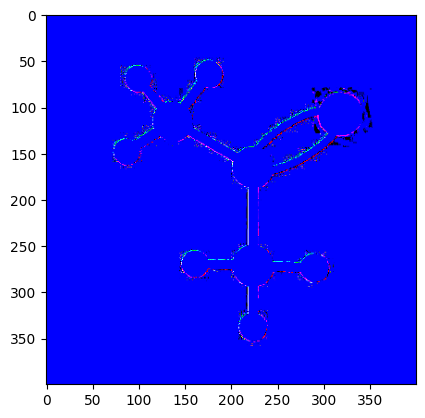

In [45]:
class ResNetBlock(torch.nn.Module):
  def __init__(self, in_channels, out_channels, size, downsampling=True):
    super().__init__()
    self.Conv2D = torch.nn.Sequential(
        torch.nn.Conv2d(in_channels, out_channels, (3,3), stride=2 if downsampling else 1, padding=(3 if size%2==0 else 2) if downsampling else 2),
        torch.nn.BatchNorm2d(out_channels),
        torch.nn.ReLU(),
        torch.nn.Conv2d(out_channels, out_channels, (3,3)),
        torch.nn.BatchNorm2d(out_channels),
    )
    self.project = torch.nn.Conv2d(in_channels, out_channels, (1,1))
    self.pooling = torch.nn.AvgPool2d((2,2)) if downsampling else torch.nn.Identity()
    self.relu = torch.nn.ReLU()
  def forward(self, images):
    x = self.Conv2D(images)
    images = self.pooling(self.project(images))
    return self.relu(x+images)
resblock = ResNetBlock(3,12,400, 0)
inp_img = torch.permute(torch.tensor(np.expand_dims(example_in, 0).astype("float32")), (0,3,1,2))
oup = resblock(inp_img)[:,-3:,:,:]
pylab.imshow(torch.permute(oup, (0,2,3,1)).cpu().detach().numpy()[0])

In [19]:
torch.permute(torch.tensor(np.expand_dims(example_in, 0).astype("float32")), (0,3,1,2)).size()

torch.Size([1, 3, 400, 400])

In [20]:
t = torch.randn(1,64,400,400)
torch.flatten(t)
torch.flatten(t, start_dim=2,end_dim=3).shape

torch.Size([1, 64, 160000])

In [135]:
class ImageEncoder(torch.nn.Module):
  def __init__(self, channels_list, heads, dropout, orginal_size):
    super().__init__()
    self.conv2d = torch.nn.Sequential(
        # torch.nn.Conv2d(3, 32, (7, 7), stride=3),
        # torch.nn.AvgPool2d((3,3), padding=1)
        torch.nn.Conv2d(3, 32, (7, 7), stride=2, padding=1),
        torch.nn.MaxPool2d((3, 3), stride=2)
    )
    self.resnet_blocks = []
    for i in range(len(channels_list)-1):
      self.resnet_blocks.append(ResNetBlock(channels_list[i], channels_list[i], size=66//(2**i)))
      self.resnet_blocks.append(ResNetBlock(channels_list[i], channels_list[i+1], size=66//(2**i), downsampling=0)) #gangcai self not defined

    self.mlp = torch.nn.Sequential(
        torch.nn.Linear(512,1024),
        torch.nn.GELU(),
        torch.nn.Linear(1024, 512),
        torch.nn.GELU(),
    )

    self.mha = torch.nn.MultiheadAttention(channels_list[-1], heads, dropout = 0.1)

  def forward(self, images):
    features = self.conv2d(images)
    for f in self.resnet_blocks:
      features = f(features)
    features = torch.flatten(features, start_dim=2, end_dim=3)
    features = torch.permute(features, (0, 2, 1))
    att = self.mha(features, features, features, need_weights=False)[0]
    return self.mlp(att) + features



In [136]:
NUM_HEADS = 8
CHANNELS = [32, 64, 128, 256, 512]
DROPOUT = 0.1

encoder = ImageEncoder(CHANNELS, NUM_HEADS, DROPOUT, 400)
encoder(inp_img).shape

torch.Size([1, 36, 512])

In [133]:
sum(p.numel() for p in encoder.parameters())

2105472

In [138]:
# from torchinfo import summary
# summary(encoder, (1,3,400,400), depth=10)

In [139]:
from torchview import draw_graph

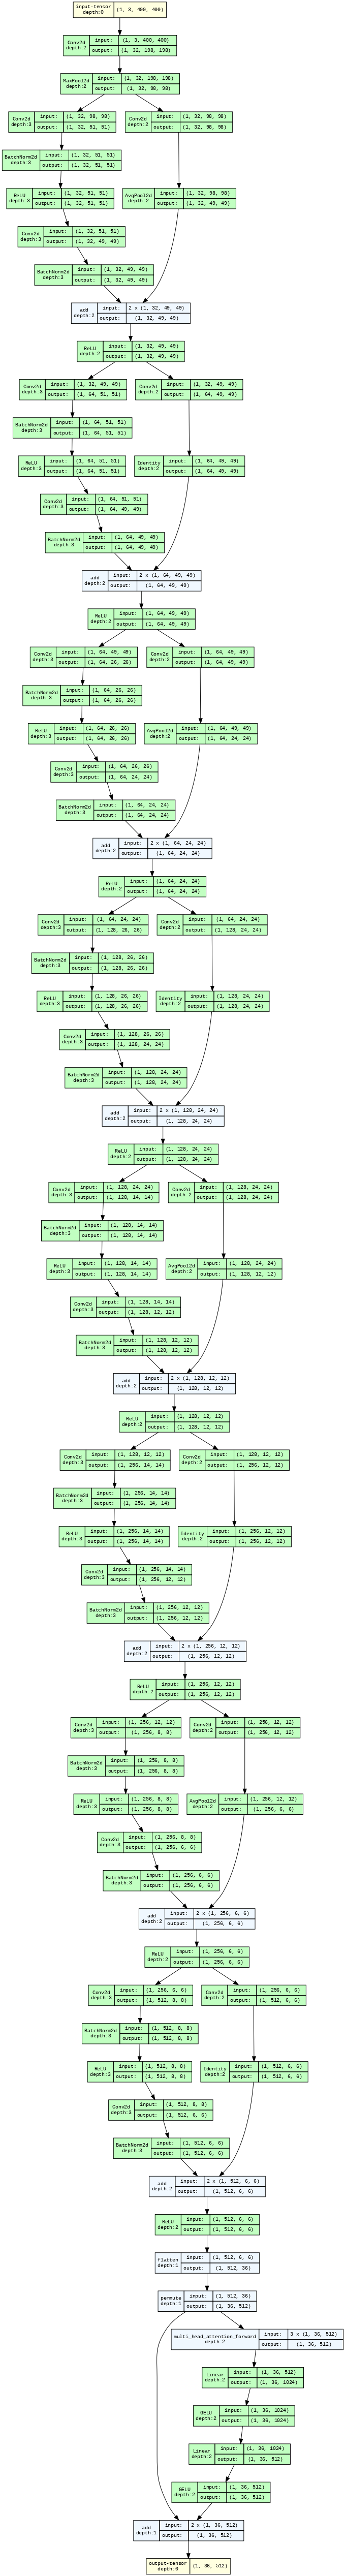

In [280]:
import graphviz
graphviz.set_jupyter_format('png')
model_graph = draw_graph(encoder, input_size=(1, 3, 400, 400), depth=5)
model_graph.visual_graph

# Connect with pretrained


In [143]:
def subsequent_mask(tgt_mask):
    size = tgt_mask.size(-1)
    return tgt_mask.to(torch.uint8) & torch.tril(torch.ones(1,size,size, dtype=torch.uint8)).to(tgt_mask.device)

def pad_pack(sequences):
    maxlen = max(map(len, sequences))
    batch = torch.LongTensor(len(sequences),maxlen).fill_(0)
    for i,x in enumerate(sequences):
        batch[i,:len(x)] = torch.LongTensor(x)
    return batch

def find_first_working(x):
  for i in x:
    if i<=71:
      return i


In [144]:
inp = M.src_model.encode("N-(4-hydroxyphenyl)acetamide")
src = torch.tensor(pad_pack([inp]), device=(M.device))
src_mask = (src != 0).unsqueeze(-2).to(M.device)#.shape
latent = M.T.encoder(M.T.src_embedder(src), (src != 0).unsqueeze(-2).to(M.device))
l = latent.to(torch.device("cpu"))
l.cpu().detach().numpy()[0].shape

<ipython-input-144-d72dba930e17>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src = torch.tensor(pad_pack([inp]), device=(M.device))


(10, 512)

In [145]:
padded_tgt = pad_pack([[2]]).to(M.device)
empty_start = M.T.tgt_embedder(padded_tgt)

In [146]:
latent = encoder(inp_img)
src_mask = (torch.zeros(len(latent[0]))).unsqueeze(-2).to(M.device)#.shape
out = M.T.decoder(empty_start, latent, src_mask, subsequent_mask((padded_tgt != 0).unsqueeze(-2)))

In [222]:
# Test for teaching forcing
# forcing = pad_pack([[2]+M.tgt_model.encode("CC(=O)Nc1ccc(O)cc")]).to(M.device)
forcing = pad_pack([[2,0]]).to(M.device)
forcing_start = M.T.tgt_embedder(forcing)

latent = encoder(inp_img)
src_mask = (src != 0).unsqueeze(-2).to(M.device)
out = M.T.decoder(forcing_start, l, src_mask, subsequent_mask((forcing != 0).unsqueeze(-2)))
out = M.T.generator(out)
print (out.shape)
ans = []
for i in range(2):
  ans.append(torch.sort(out[0], dim=1,
                        descending=True)[1].cpu().detach().numpy()[i][0])
M.tgt_model.decode(ans)

torch.Size([1, 2, 72])


'CC'

In [148]:
# https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
for i in M.T.decoder.parameters():
  i.requires_grad == False

for i in M.T.generator.parameters():
  i.requires_grad == False

In [230]:
class Image2SMILES(torch.nn.Module):
  def __init__(self, encoder, embeding, decoder, generator):
    super().__init__()
    self.encoder = encoder
    self.embeding = embeding
    self.decoder = decoder
    self.generator = generator

  def forward (self, image, text_in):
    image_feature = self.encoder(image)
    paded = pad_pack(text_in)
    embedded = self.embeding(paded)
    out = self.decoder(embedded, image_feature,
                       torch.zeros(36).unsqueeze(-2).to(M.device),
                       subsequent_mask((paded != 0)
                       .unsqueeze(-2)))
    out = self.generator(out)
    return out

In [272]:
class SMILESGenerator(torch.nn.Module):
  def __init__(self, encoder, embeding, decoder, generator, max_len):
    super().__init__()
    self.encoder = encoder
    self.embeding = embeding
    self.decoder = decoder
    self.generator = generator
    self.max_len = max_len

  def forward (self, image, text_in):
    image_feature = self.encoder(image)
    for i in range(self.max_len):
      paded = pad_pack(text_in)
      embedded = self.embeding(paded)
      out = self.decoder(embedded, image_feature,
                        torch.zeros(36).unsqueeze(-2).to(M.device),
                        subsequent_mask((paded != 0)
                        .unsqueeze(-2)))
      out = self.generator(out)
      next = torch.sort(out, descending=True)[1][0,0].cpu().detach().numpy()[0] #forgot descending
      if next == 3:
        break
      text_in[0] += [next]
      print(text_in)
    return M.tgt_model.decode(text_in[0])


In [231]:
model = Image2SMILES(encoder,
    M.T.tgt_embedder,
             M.T.decoder, M.T.generator)

In [273]:
gen = SMILESGenerator(encoder,
    M.T.tgt_embedder,
             M.T.decoder, M.T.generator, 10)

In [277]:
torch.argmax(model(inp_img, [[2, 0]])[0,0])

tensor(37)

In [276]:
gen(inp_img, [[2]])

[[2, 37]]
[[2, 37, 37]]
[[2, 37, 37, 37]]
[[2, 37, 37, 37, 37]]
[[2, 37, 37, 37, 37, 37]]
[[2, 37, 37, 37, 37, 37, 37]]
[[2, 37, 37, 37, 37, 37, 37, 37]]
[[2, 37, 37, 37, 37, 37, 37, 37, 37]]
[[2, 37, 37, 37, 37, 37, 37, 37, 37, 37]]
[[2, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37]]


'NNNNNNNNNN'

In [251]:
def softmax(x):
  t = np.exp(x)
  return t/np.sum(t)

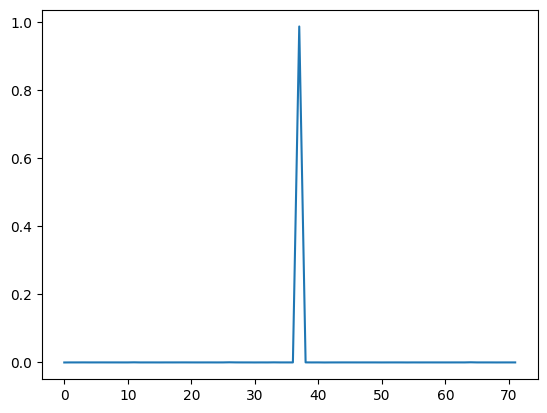

In [252]:
pylab.plot(softmax(model(inp_img, [[2, 0]])[0][0].cpu().detach().numpy()))

In [260]:
M.tgt_model.decode([37])

'N'

# Training


In [323]:
BATCH_SIZE = 32
files = os.listdir("rendered")


def getitiem(index):
  start_index = index * BATCH_SIZE
  Xs_img = []
  Xs_text = []
  y = [] #This is slow, rewrite later
  for _ in range(BATCH_SIZE):
    index = start_index + _
    try:
      id = int(files[index].split("_")[0])
    except:
      break
    index = start_index + _
    img = np.array(Image.open(f"rendered/{files[index]}").rotate(np.random.uniform(0,360), expand = 1).resize((400,400)), dtype="float32")
    noise = np.random.uniform(size=img.shape)*20
    img += noise
    Xs_img.append(img)
    Xs_text.append([2] + Ys[id])
    y.append(Ys[id] + [3])
  Xs_img = torch.permute(torch.tensor(Xs_img), (0,3,1,2))
  return [Xs_img, pad_pack(Xs_text)], pad_pack(y)

In [291]:
%timeit getitiem(1)

1.58 s ± 337 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [303]:
data = getitiem(1)

In [302]:
data[0][1].size(), data[1].size()

(torch.Size([64, 42]), torch.Size([64, 42]))

In [309]:
model(inp_img, [[2, 0]]).size()

torch.Size([1, 2, 72])

In [336]:
lf = torch.nn.CrossEntropyLoss()
def loss_fn(pred, truth):
  return lf(pred, torch.nn.functional.one_hot(truth, num_classes=72).type(torch.float32))

In [ ]:
# https://pytorch.org/tutorials/beginner/introyt/trainingyt.html

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(30):
  np.random.shuffle(files)
  print('EPOCH {}:'.format(epoch + 1))
  model.train(True)
  running_loss = 0.
  last_loss = 0.
  for i in range(len(files)//BATCH_SIZE):
    (image, text_in), text_out = getitiem(i)
    optimizer.zero_grad()
    outputs = model(image, text_in)
    loss = loss_fn(outputs, text_out)
    loss.backward()

    optimizer.step()

    running_loss += loss.item()
    if i%10 == 0:
      print(f"Training loss: {running_loss/10}")
      running_loss = 0.


In [315]:
outputs.shape

torch.Size([64, 32, 72])

In [320]:
torch.nn.functional.one_hot(data[1], num_classes=72).size()

torch.Size([64, 42, 72])